In [314]:

## Import Python libraries


import pandas as pd



import numpy as np



import matplotlib.pyplot as plt


import matplotlib.ticker as ticker

from matplotlib.ticker import FuncFormatter


import seaborn as sns



from sklearn.compose import ColumnTransformer



from sklearn.pipeline import make_pipeline



from sklearn.preprocessing import(
    
    
    
    FunctionTransformer,
    
    

    
    StandardScaler
    
    
)



from sklearn.model_selection import train_test_split



from sklearn.pipeline import Pipeline



import xgboost as xgb



from xgboost import XGBRegressor 



from sklearn.metrics import mean_absolute_error



from sklearn.metrics import r2_score



from sklearn.metrics import mean_poisson_deviance



from scipy.special import factorial



from scipy.optimize import minimize



from sklearn.base import BaseEstimator, RegressorMixin



from sklearn.model_selection import  KFold







We use the features selected via regularization to train the XGBoost model with a Poisson loss function



This approach helps us identify the most important features associated with lung cancer prevalence



Before training the model, we highlight the key model settings




A custom Poisson loss function is required in this Python code










## XGBoost Poisson Regression








Let $Y_{i}$ denote the observed count over region $A_{i}$ with rate $\lambda_{i}$


In our case, $A_{i} = N_{i}$ refers to the total population (or Population aged 18 and over) and $\lambda_{i}$ denotes the lung cancer incidence rate


We assume that

\begin{align}
 Y_{i} \sim Poisson(N_{i}\lambda_{i})
\end{align}


The Poisson probability mass function is given by
\begin{align}
 P(Y_{i} = y_{i}) = \frac{e^{-N_{i}\lambda_{i}} (N_{i}\lambda_{i})^{y_{i}}}{y_{i}!}
\end{align}



We model the rate $\lambda_{i}$ using tree at $t$-th  iteration and it is given by

\begin{align}
\log(\lambda_{i}) = f(\mathbf{x}_{i}, \eta_{t})
\end{align}



Let $\mathbf{x} = (\mathbf{x}_{1}, \mathbf{x}_{2}, \cdots,  \mathbf{x}_{n})',\; $ $\mathbf{y} = (y_{1}, y_{2}, \cdots,  y_{n})',\;$ \; $\boldsymbol\lambda = (\lambda_{1}, \lambda_{2}, \cdots,  \lambda_{n})$'



 
The log-likelihood function for the $n$ independent observations $\mathbf{y}$ can be given by

\begin{align}
\ell(\boldsymbol\lambda\mid \mathbf{y}, \mathbf{x}) = \sum_{i = 1}^{n}{(y_{i} \log(N_{i}\lambda_{i}) -  N_{i}\lambda_{i} - \log(y_{i}!))}
\end{align}


 Ignoring constants, we have that
\begin{align}
\ell(\boldsymbol\lambda\mid \mathbf{y}, \mathbf{x}) \approx \sum_{i = 1}^{n}{(y_{i} \log(N_{i}\lambda_{i}) -  N_{i}\lambda_{i} - \log(y_{i}!))}
\end{align}


Substituting $\lambda_{i} = e^{f(\mathbf{x}_{i}, \;\eta_{t})}$, we have


\begin{align}
\ell(\eta_{t}\mid \mathbf{y}, \mathbf{x})
&\approx \sum_{i = 1}^{n}{(y_{i} f(\mathbf{x}_{i},\; \eta_{t}) -  N_{i}e^{f(\mathbf{x}_{i}, \;\eta_{t})}})
\end{align}


In XGBoost Poisson Loss function, we minimize the objective function given by 

\begin{align}
L(\eta_{t}\mid \mathbf{y}, \mathbf{x}) = -\ell(\eta_{t}\mid \mathbf{y}, \mathbf{x})
\end{align}
That is,

\begin{align}
L(\eta_{t}\mid \mathbf{y}, \mathbf{x}) =  \sum_{i = 1}^{n}{(N_{i}e^{f(\mathbf{x}_{i}, \;\eta_{t})}}- y_{i} f(\mathbf{x}_{i},\; \eta_{t}))
\end{align}



Next, we derive gradients:




Gradient: 

\begin{align}
\frac{dL}{df(\mathbf{x}_{i},\; \eta_{t})} = \sum_{i = 1}^{n}{(N_{i}e^{f(\mathbf{x}_{i}, \;\eta_{t})}}- y_{i})
\end{align}


Hessian: 

\begin{align}
\frac{d^{2}L}{df(\mathbf{x}_{i},\; \eta_{t})^{2}} = \sum_{i = 1}^{n}{N_{i}e^{f(\mathbf{x}_{i}, \;\eta_{t})}}
\end{align}




We use the gradient and Hessian in XGBoost’s custom objective function for efficient optimization



In [63]:

# Read the data sets




selectedxtrain = pd.read_csv("../Data/xtrain_features_selected.csv")





selectedxtest = pd.read_csv("../Data/xtest_features_selected.csv")




N_train = pd.read_csv("../Data/Ntrain.csv")





N_test = pd.read_csv("../Data/Ntest.csv")



y_train = pd.read_csv("../Data/ytrain.csv")





y_test = pd.read_csv("../Data/ytest.csv")






selected_xtrain = selectedxtrain.copy(deep = True)




selected_xtest = selectedxtest.copy(deep = True)








In [9]:

selected_xtrain.head()



,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_Hisp_65andOver,Pct_Hisp_Female_65andOver,BINGE_CrudePrev,CSMOKING_CrudePrev,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
0,10.945890,9.954564,7.765386,0.000000,13.052458,5.617513,0.536968,0.536968,17.5,24.1,36.8,61429.0,7.600453,47.0,38.166047,35.563817,3.634862,0.784800,1.982652
1,5.487995,13.314624,15.060804,0.000000,28.375429,13.314624,0.280636,0.000000,15.7,18.3,33.2,69629.0,6.803544,12.0,38.072965,32.616152,0.062364,0.093545,0.000000
2,4.664634,9.146341,10.121951,0.426829,18.841463,9.146341,0.274390,0.274390,19.2,19.7,31.7,82471.0,6.668248,9.0,38.902439,35.609756,1.615854,0.853659,1.067073
3,27.673653,5.239207,7.018670,1.228121,9.839557,4.466161,0.035006,0.035006,19.1,16.6,26.6,63339.0,7.317931,69.0,31.341890,30.845974,6.324387,2.514586,1.481914
4,8.228571,15.600000,16.342857,3.371429,27.828571,14.857143,0.000000,0.000000,15.7,15.7,30.9,84792.0,7.483860,19.0,30.057143,37.028571,0.000000,6.057143,4.971429


In [10]:


selected_xtest.head()




,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_Hisp_65andOver,Pct_Hisp_Female_65andOver,BINGE_CrudePrev,CSMOKING_CrudePrev,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
0,11.188463,20.537046,18.050721,2.237693,33.764296,18.199901,0.497265,0.497265,12.3,20.8,36.7,52179.0,7.982785,26.0,22.774739,28.194928,4.127300,0.447539,0.000000
1,14.055944,15.734266,16.503497,2.587413,23.496503,9.580420,0.000000,0.000000,16.7,20.4,35.4,59882.0,7.552918,31.0,28.321678,30.069930,3.636364,0.000000,0.000000
2,11.449659,16.748675,14.629069,0.000000,29.712339,16.218774,1.116578,1.116578,16.5,20.1,34.7,66000.0,7.617609,26.0,32.172597,33.535201,1.324754,0.000000,0.000000
3,14.330844,13.181944,15.120465,4.984769,20.022155,10.135696,1.633896,0.000000,13.8,19.3,42.3,41611.0,6.765537,67.0,22.846857,26.613127,10.108003,4.403212,3.904736
4,19.202419,13.785701,15.083069,1.213366,26.068695,12.292328,0.326675,0.102669,14.1,26.0,37.3,33788.0,7.696925,70.0,28.290088,30.679485,4.741460,1.717379,1.876050


In [47]:


selected_xtrain.shape



(551, 19)

In [48]:


selected_xtest.shape



(237, 19)

In [49]:

## We select the features with percentage values and those with non-percentage values


columnsnew = selected_xtrain.columns.tolist()


columnsnew


['Pct_BelowPoverty_18andOver',
 'Pct_Population_Male_65andOver',
 'Pct_Population_Female_65andOver',
 'Pct_Black_Female_65andOver',
 'Pct_White_65andOver',
 'Pct_White_Male_65andOver',
 'Pct_Hisp_65andOver',
 'Pct_Hisp_Female_65andOver',
 'BINGE_CrudePrev',
 'CSMOKING_CrudePrev',
 'OBESITY_CrudePrev',
 'Median_Household_Income',
 'ZCTA_pm2_5',
 'sdi_score',
 'Pct_White_Male_Between18and65',
 'Pct_White_Female_Between18and65',
 'Pct_Black_Female_Between18and65',
 'Pct_Hisp_Male_Between18and65',
 'Pct_Hisp_Female_Between18and65']

In [50]:

# Original features



## Features with percentage values



columnnamesa = ["Pct_Civilian_Unemployed", 
                            "Pct_BelowPoverty_18andOver",
                            "Pct_Population_Male_65andOver", "Pct_Population_Female_65andOver",
                            "Pct_Black_65andOver","Pct_Black_Male_65andOver", 'Pct_Black_Female_65andOver',
                            "Pct_White_65andOver","Pct_White_Male_65andOver", "Pct_White_Female_65andOver",
                            "Pct_Hisp_65andOver", "Pct_Hisp_Male_65andOver", "Pct_Hisp_Female_65andOver",
                            "Pct_White_Male_Between18and65", "Pct_White_Female_Between18and65",
                            "Pct_Black_Female_Between18and65", "Pct_Black_Male_Between18and65",
                            "Pct_Hisp_Male_Between18and65", "Pct_Hisp_Female_Between18and65"]




# Features with non-percentage values



columnnamesb =  ["BINGE_CrudePrev", "CSMOKING_CrudePrev", 
                                                       
                             "OBESITY_CrudePrev",
                             "Median_Household_Income", "ZCTA_pm2_5", "sdi_score"]





In [51]:

# Features with percentage values selected by the regularization 




selected_columnsa = pd.Series(columnnamesa)[pd.Series(columnnamesa).isin(columnsnew)].tolist()



# Features with non-percentage values selected by the regularization 



selected_columnsb = pd.Series(columnnamesb)[pd.Series(columnnamesb).isin(columnsnew)].tolist()






In [52]:

selected_columnsa



['Pct_BelowPoverty_18andOver',
 'Pct_Population_Male_65andOver',
 'Pct_Population_Female_65andOver',
 'Pct_Black_Female_65andOver',
 'Pct_White_65andOver',
 'Pct_White_Male_65andOver',
 'Pct_Hisp_65andOver',
 'Pct_Hisp_Female_65andOver',
 'Pct_White_Male_Between18and65',
 'Pct_White_Female_Between18and65',
 'Pct_Black_Female_Between18and65',
 'Pct_Hisp_Male_Between18and65',
 'Pct_Hisp_Female_Between18and65']

In [53]:


selected_columnsb


['BINGE_CrudePrev',
 'CSMOKING_CrudePrev',
 'OBESITY_CrudePrev',
 'Median_Household_Income',
 'ZCTA_pm2_5',
 'sdi_score']

In [54]:



# selected_columnsa: transform percentage to decimal



selected_xtrain[selected_columnsa] = selected_xtrain[selected_columnsa] / 100




selected_xtest[selected_columnsa] = selected_xtest[selected_columnsa] / 100





In [55]:


# selected_columnsb: standardize the features



scaler = StandardScaler()




# Fit and transform the training data



selected_xtrain[selected_columnsb] = scaler.fit_transform(selected_xtrain[selected_columnsb])




# Apply the same transformation to the test data (using the learned parameters)




selected_xtest[selected_columnsb] = scaler.transform(selected_xtest[selected_columnsb])





In [56]:


selected_xtrain.head()



,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_Hisp_65andOver,Pct_Hisp_Female_65andOver,BINGE_CrudePrev,CSMOKING_CrudePrev,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
0,0.109459,0.099546,0.077654,0.000000,0.130525,0.056175,0.005370,0.005370,0.815147,0.973795,0.536559,-0.096117,-0.021411,0.287624,0.381660,0.355638,0.036349,0.007848,0.019827
1,0.054880,0.133146,0.150608,0.000000,0.283754,0.133146,0.002806,0.000000,-0.034346,-0.378743,-0.181072,0.169842,-1.713352,-1.174760,0.380730,0.326162,0.000624,0.000935,0.000000
2,0.046646,0.091463,0.101220,0.004268,0.188415,0.091463,0.002744,0.002744,1.617445,-0.052268,-0.480085,0.586360,-2.000604,-1.300107,0.389024,0.356098,0.016159,0.008537,0.010671
3,0.276737,0.052392,0.070187,0.012281,0.098396,0.044662,0.000350,0.000350,1.570251,-0.775177,-1.496730,-0.034168,-0.621242,1.206836,0.313419,0.308460,0.063244,0.025146,0.014819
4,0.082286,0.156000,0.163429,0.033714,0.278286,0.148571,0.000000,0.000000,-0.034346,-0.985053,-0.639559,0.661640,-0.268954,-0.882283,0.300571,0.370286,0.000000,0.060571,0.049714


In [57]:


selected_xtest.head()




,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_Hisp_65andOver,Pct_Hisp_Female_65andOver,BINGE_CrudePrev,CSMOKING_CrudePrev,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
0,0.111885,0.205370,0.180507,0.022377,0.337643,0.181999,0.004973,0.004973,-1.638944,0.204248,0.516625,-0.396132,0.790328,-0.589806,0.227747,0.281949,0.041273,0.004475,0.000000
1,0.140559,0.157343,0.165035,0.025874,0.234965,0.095804,0.000000,0.000000,0.437594,0.110969,0.257480,-0.146293,-0.122334,-0.380895,0.283217,0.300699,0.036364,0.000000,0.000000
2,0.114497,0.167487,0.146291,0.000000,0.297123,0.162188,0.011166,0.011166,0.343206,0.041010,0.117941,0.052139,0.015012,-0.589806,0.321726,0.335352,0.013248,0.000000,0.000000
3,0.143308,0.131819,0.151205,0.049848,0.200222,0.101357,0.016339,0.000000,-0.931033,-0.145547,1.632941,-0.738895,-1.794047,1.123271,0.228469,0.266131,0.101080,0.044032,0.039047
4,0.192024,0.137857,0.150831,0.012134,0.260687,0.122923,0.003267,0.001027,-0.789451,1.416868,0.636230,-0.992627,0.183412,1.248618,0.282901,0.306795,0.047415,0.017174,0.018761


In [189]:

N_train.head()


,Population_18andOver
0,2421
1,3207
2,3280
3,34280
4,1750


In [190]:


N_test.head()




,Population_18andOver
0,2011
1,1430
2,5284
3,3611
4,10714


In [65]:

print("xtrain data size:", selected_xtrain.shape)


print("Ntrain data size:", N_train.shape)


print("ytrain data size:", y_train.shape)


print("xtest data size:", selected_xtest.shape)



print("Ntest data size:", N_test.shape)



print("ytest data size:", y_test.shape)




xtrain data size: (551, 19)
Ntrain data size: (551, 1)
ytrain data size: (551, 1)
xtest data size: (237, 19)
Ntest data size: (237, 1)
ytest data size: (237, 1)


In [66]:

X = np.copy(selected_xtrain)


ytrain = np.copy(y_train)



weight = np.copy(N_train)



In [67]:



dtrain = xgb.DMatrix(X, label = ytrain, weight = weight)



print(dtrain.num_row())



print(dtrain.num_col())




551
19


In [68]:


X = selected_xtest




dtest = xgb.DMatrix(X, label = y_test, weight = N_test)





In [241]:

ytrain = ytrain



X = selected_xtrain



weight = N_train.squeeze()





The learning rate in XGBoost, which controls how much each new tree corrects errors from previous trees,  can be selected through cross-validation



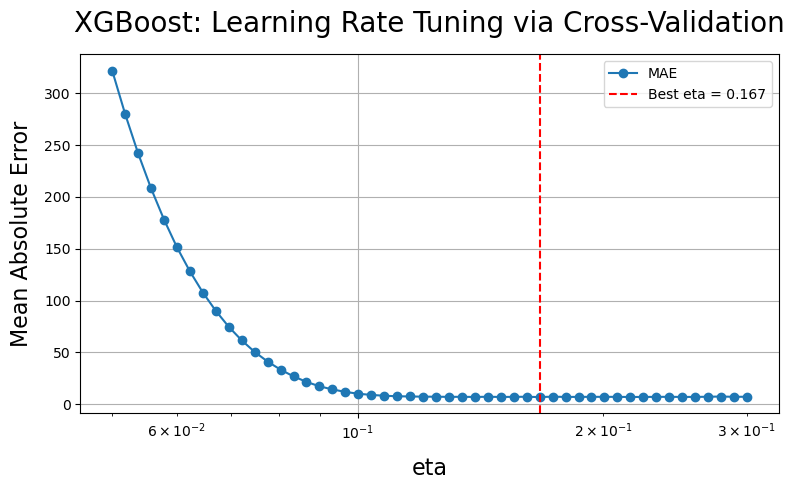

0.167

In [381]:



# Logarithmic spacing of the learning rate eta


etas = np.logspace(np.log10(0.05), np.log10(0.3), 50)


mae_values = []


best_mae = float("inf")


best_eta = None



for eta in etas:
  

    params = {
        
        'max_depth': 7,

        
        'eta': eta,

        
        'lambda': 0.25

        
    }
    

    dtrain = xgb.DMatrix(selected_xtrain, label = ytrain, weight = N_train.squeeze())

    
    def poisson_objective(preds, dtrain):

        
        y_true = dtrain.get_label()

        
        N_i = dtrain.get_float_info('weight')


        preds_exp = np.exp(preds)

        
        grad = N_i * preds_exp - y_true

        
        hess = N_i * preds_exp


        
        return grad, hess

    def custom_mae_metric(preds, dtrain):


        
        y_true = dtrain.get_label()

        
        N_i = dtrain.get_weight()


        
        mu = N_i * np.exp(preds)


        
        mae = np.mean(np.abs(y_true - mu))


        
        return 'MAE', mae

    

    cv_results = xgb.cv(

        
        params = params,

        
        dtrain = dtrain,

        
        num_boost_round = 75,

        
        nfold = 5,

        
        obj = poisson_objective,


        
        custom_metric = custom_mae_metric,


        
        early_stopping_rounds = 1000,

        
        seed = 42
    )

    min_mae = cv_results['test-MAE-mean'].min()


    
    mae_values.append(min_mae)

    

    if min_mae < best_mae:

        
        best_mae = min_mae

        
        best_eta = eta



# Plotting eta vs MAE


plt.figure(figsize = (8, 5))


plt.plot(etas, mae_values, marker = 'o', label = 'MAE')


plt.axvline(best_eta, color = 'red', linestyle = '--', label = f'Best eta = {best_eta:.3f}')


plt.xlabel('eta', fontsize = 16, labelpad = 11)



plt.ylabel('Mean Absolute Error', fontsize = 16, labelpad = 8)



plt.xscale('log')


plt.legend()


plt.grid(True)



plt.title("XGBoost: Learning Rate Tuning via Cross-Validation", fontsize = 20,  pad = 16)


plt.tight_layout()


plt.savefig('../Results/cross_validation_xgboost_eta.png', dpi = 300)



plt.show()



besteta = round(best_eta, 3)



besteta



In [274]:



## Fitting XGBoost with Poisson Loss function



# Custom objective for Poisson regression



# Ensures the model optimizes for Poisson regression



def poisson_objective(preds, dtrain):
    

    
    y_true = dtrain.get_label()
    
    
    N_i = dtrain.get_float_info('weight')  
    
    
    preds = np.exp(preds)
    
    
    grad = N_i * preds - y_true
    
    
    hess = N_i * preds
    
    
    return grad, hess



dtrain = xgb.DMatrix(X, label = ytrain, weight = weight)


params = {

    'max_depth': 7,

    
    'eta': besteta    
}



model = xgb.train(
    
    
    params,
    

    
    dtrain,
    
    
    
    num_boost_round = 75,
    
    
    
    obj = poisson_objective)



preds = model.predict(dtest)



poisson_preds = N_test.squeeze()*np.exp(preds)




mae = np.mean(abs(y_test.squeeze() - poisson_preds.squeeze()))



print(f"MAE: {mae}")



MAE: 5.963415427721904


In [344]:


# Save the results, as training takes time



pd.DataFrame([{'besteta_xgboost': besteta}]).to_csv('../Results/besteta_xgbooet.csv', index = False)



pd.DataFrame([{'mae_xgboost': mae}]).to_csv('../Results/mae_xgboost.csv', index = False)


pd.DataFrame([{'etas_xgboost': etas}]).to_csv('../Results/etas_xgboost.csv', index = False)



pd.DataFrame([{'mae_values_xgboost': mae_values}]).to_csv('../Results/mae_values_xgboost.csv', index = False)






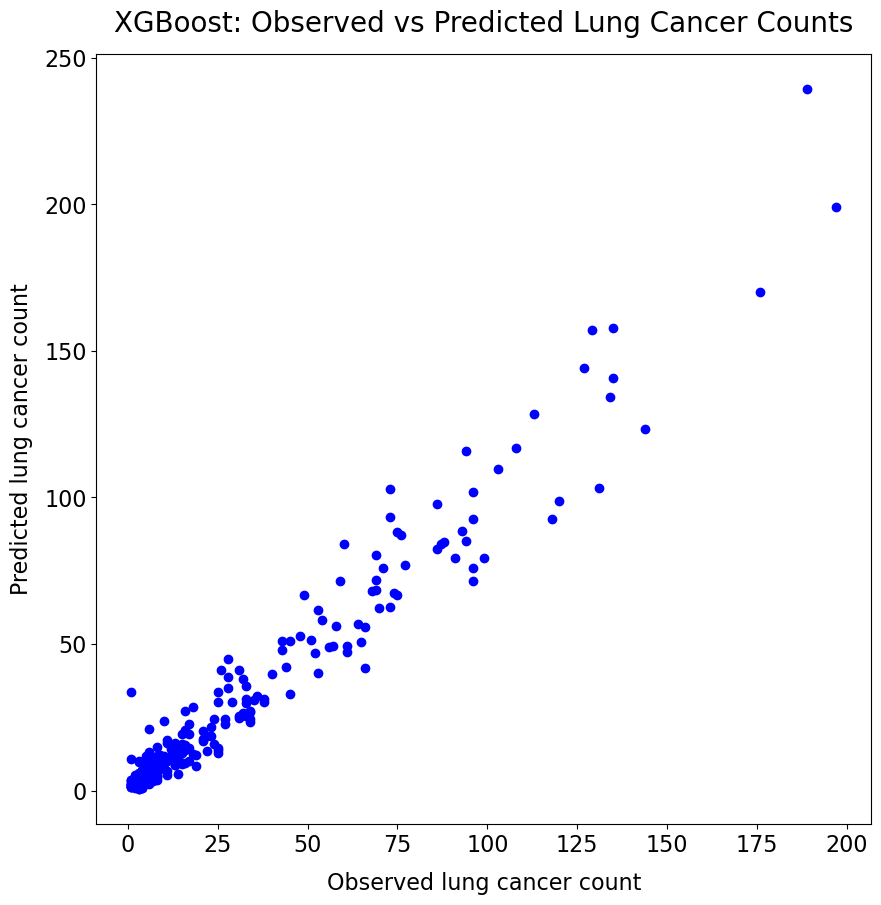

In [382]:


plt.figure(figsize=(10, 10))



plt.scatter(y_test, poisson_preds, color='blue')



plt.xlabel('Observed lung cancer count', fontsize=16, labelpad = 11)



plt.ylabel('Predicted lung cancer count', fontsize=16, labelpad = 8)



plt.title('XGBoost: Observed vs Predicted Lung Cancer Counts', fontsize = 20, pad = 16)



plt.tick_params(axis='both', which='major', labelsize=16)



plt.grid(False)



plt.savefig('../Results/ytestypredictxgboost.png', dpi=300)



plt.show()



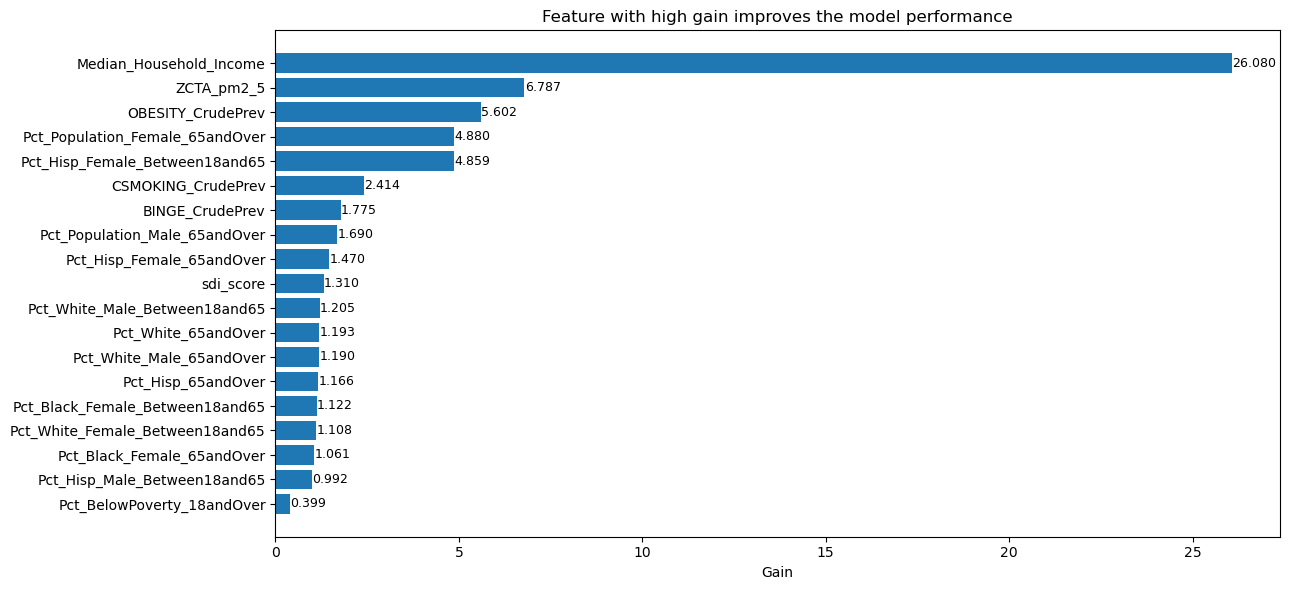

In [338]:


# Plot feature importance


## The average gain in accuracy (reduction in loss) brought by a feature when it is used in splits


## Gain it reflects the impact of a feature on the performance of the model


## A feature with high gain improves the model performance 


# Extract gain-based feature importance


importance_dict = model.get_score(importance_type = 'gain')



importance_df = pd.DataFrame.from_dict(importance_dict, orient = 'index', columns = ['Gain'])



importance_df = importance_df.sort_values(by = 'Gain', ascending = True)



# Plot manually with formatted gains


plt.figure(figsize=(13, 6))



bars = plt.barh(importance_df.index, importance_df['Gain'])



# Add values at the end of each bar with 3 decimal places



for bar in bars:

    
    width = bar.get_width()


    
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,

             
             f'{width:.3f}', va = 'center', fontsize = 9)

# Title and labels


plt.title("Feature with high gain improves the model performance")


plt.xlabel("Gain")



# Adjust layout and save



plt.tight_layout()



plt.savefig('../Results/Feature_importance_xgboost.png', dpi=300)



plt.show()





In [339]:


# Extract feature importance into a DataFrame



importance_df = pd.DataFrame(model.get_score(importance_type = 'gain').items(),
                             
                             
                             
    columns=["Feature", "Importance"]
                             
                             
                             
)



print(importance_df.sort_values(by='Importance', ascending = False))






                            Feature  Importance
11          Median_Household_Income   26.079531
12                       ZCTA_pm2_5    6.787078
10                OBESITY_CrudePrev    5.602087
2   Pct_Population_Female_65andOver    4.880141
18   Pct_Hisp_Female_Between18and65    4.858813
9                CSMOKING_CrudePrev    2.414402
8                   BINGE_CrudePrev    1.774759
1     Pct_Population_Male_65andOver    1.690470
7         Pct_Hisp_Female_65andOver    1.469903
13                        sdi_score    1.310213
14    Pct_White_Male_Between18and65    1.205165
4               Pct_White_65andOver    1.192726
5          Pct_White_Male_65andOver    1.190374
6                Pct_Hisp_65andOver    1.166120
16  Pct_Black_Female_Between18and65    1.122374
15  Pct_White_Female_Between18and65    1.107857
3        Pct_Black_Female_65andOver    1.060693
17     Pct_Hisp_Male_Between18and65    0.991984
0        Pct_BelowPoverty_18andOver    0.399131


In [369]:



## save the importance table as figure


## Sort and round your importance table



importance_df = importance_df.sort_values(by = 'Importance', ascending = False)



importance_df['Importance'] = importance_df['Importance'].round(3)




# Set up the figure


fig, ax = plt.subplots(figsize = (9, len(importance_df)*0.5))  # Adjust height based on number of rows



ax.axis('off')  



# Add the table


table = ax.table(cellText = importance_df.values,

                 
    colLabels = importance_df.columns,


                 
    cellLoc = 'center',


                 
    loc = 'center'

                 
)

table.auto_set_font_size(False)


table.set_fontsize(10)


table.scale(1, 1.5)  


# Increase font size of table cells and column labels



table.auto_set_font_size(False)  # Disable automatic font size adjustment



table.set_fontsize(12)  # Set font size for table cells





for (i, j), cell in table.get_celld().items():

    
    if (j == 0):  

        
        cell.set_text_props(ha = 'left')



caption = "Table 2: Gain-based Feature Importance"



fig.text(0.5, 0.79, caption, ha='center', va='center', fontsize = 16)


column_width = 0.3  



table.auto_set_column_width([1]) 



table.auto_set_column_width([0])  


# Save the figure


plt.savefig('../Results/Feature_importance_xgboost.png', dpi = 300, bbox_inches = 'tight')


plt.close()

